In [1]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
D:\anaconda\envs\seada\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\seada\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\seada\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\seada\lib\site-packages\tensorflow\python\framework\dtypes.py:461: Fu

In [3]:
# 加载VGG16预训练模型
model = vgg16.VGG16(weights='imagenet')

D:\anaconda\envs\seada\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Predicted: [('n02007558', 'flamingo', 0.99999607), ('n02006656', 'spoonbill', 1.8544616e-06), ('n02009912', 'American_egret', 8.5071696e-07)]


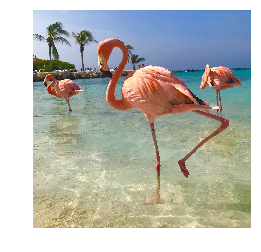

In [4]:
# 导入火烈鸟图片
img_path = 'flamingo.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# 和之前一样
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# 第一次预测
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

In [5]:
# 逆转处理过程
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
# plot_img(x)

In [6]:
sess = K.get_session()
# 生成对抗性图片
x_adv = x
# 添加噪声
x_noise = np.zeros_like(x)

0 0.9999956 [('n02007558', 'flamingo', 0.9999956), ('n02006656', 'spoonbill', 2.0940493e-06), ('n02009912', 'American_egret', 9.710699e-07)]
20 0.9999491 [('n02007558', 'flamingo', 0.9999491), ('n02006656', 'spoonbill', 1.9610497e-05), ('n02009912', 'American_egret', 1.08507675e-05)]
40 0.999637 [('n02007558', 'flamingo', 0.999637), ('n02006656', 'spoonbill', 0.00011842114), ('n02009912', 'American_egret', 7.331572e-05)]
60 0.99812275 [('n02007558', 'flamingo', 0.99812275), ('n02006656', 'spoonbill', 0.0005140069), ('n02009912', 'American_egret', 0.00035199246)]
80 0.99239904 [('n02007558', 'flamingo', 0.99239904), ('n02006656', 'spoonbill', 0.0017014268), ('n02009912', 'American_egret', 0.0012523659)]
100 0.976348 [('n02007558', 'flamingo', 0.976348), ('n02006656', 'spoonbill', 0.004375022), ('n02012849', 'crane', 0.0034781264)]
120 0.93764174 [('n02007558', 'flamingo', 0.93764174), ('n02006656', 'spoonbill', 0.009315101), ('n02012849', 'crane', 0.00835958)]
140 0.85389256 [('n0200755

D:\anaconda\envs\seada\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


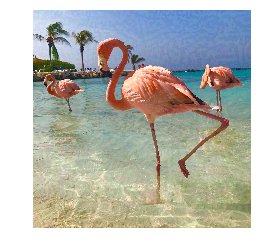

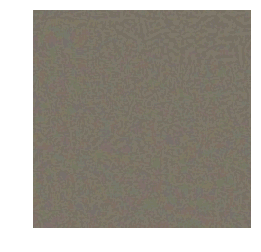

In [7]:
# 设置变量
epochs = 400
epsilon = 0.01
prev_probs = []

for i in range(epochs): 
    target = K.one_hot(initial_class, 1000)
    
    loss = K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    x_adv = x_adv + epsilon*delta

    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    prev_probs.append(preds[0][initial_class])

    if i%20==0:
        print(i, preds[0][initial_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)

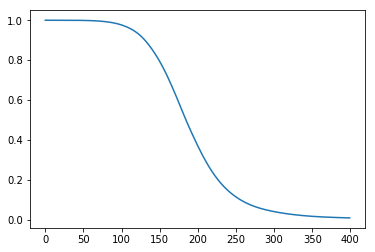

In [8]:
# Plot the probability of the target class wrt epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)
plt.show()

In [0]:
np.save('x', x)
np.save('x_adv', x_adv)